In [1]:
import sys
sys.path.append('../Util')
import pickle
import os

In [2]:
from IPython.display import Image

In [3]:
from evaluation import correlation, lr, perceptron, get_anova_dims, get_mi_dims
from preparation import prepare_dataset, read_datasets

In [4]:
from we import get_we, initiate_model

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from tqdm import tqdm

In [7]:
from scipy.stats import f_oneway

In [8]:
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
models = [
    {
        'name': 'flaubert/flaubert_small_cased',
        'label': 'flau_small_c'
    },
    {
    
        'name': 'flaubert/flaubert_base_uncased', 
        'label': 'flau_base_u'

    },
    {
        'name': 'flaubert/flaubert_base_cased',
        'label': 'flau_base_c'
    },
    {
        'name': 'flaubert/flaubert_large_cased',
        'label': 'flau_large_c'
    },
    {
        'name': 'camembert/camembert-base',
        'label': 'cam_base'
    },
    {
        'name': 'xlm-roberta-large',
        'label': 'xlm_large'
    },
    {
    
        'name': 'xlm-roberta-base', 
        'label': 'xlm_base'

    },
    {
        'name': 'bert-base-multilingual-uncased',
        'label': 'bert_base_u'
    },
    {
        'name': 'distilbert-base-multilingual-cased',
        'label': 'distilbert_base'
    },
    {
        'name': 'bert-base-multilingual-cased',
        'label': 'bert_base_c'
    }
    
]

In [11]:
labels = [m['label'] for m in models]

In [13]:
def get_inf_enc(test_name, labels):
    with open(f'../Data/best_results/{test_name}_accs.pickle', 'rb') as f:
        accs = pickle.load(f)
    with open(f'../Data/best_results/{test_name}_dims.pickle', 'rb') as f:
        dims = pickle.load(f)
        
    avg_accs = {}
    for i in range(len(labels)):
        avg_accs[labels[i]] = {}
        for dim_group in dims[labels[i]].keys():
            avg_accs[labels[i]][dim_group] = np.average(accs[labels[i]][dim_group])
    
    avg_df = pd.DataFrame(avg_accs)
    
    return pd.Series([avg_df.loc[avg_df.idxmax()[i], labels[i]] for i in range(len(models))], index=labels)

In [14]:
task_labels = [
    'Gen_N',
    'Gen_A',
    'Gen_N+A',
    'Num_N',
    'Num_A',
    'Num_N+A',
    'POS_N',
    'POS_A',
    'POS_V',
    'Sem_Act',
    'Sem_Person'
]

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [16]:
clfs = [KNeighborsClassifier, GaussianNB, LogisticRegression, RandomForestClassifier, DecisionTreeClassifier]

In [17]:
corr_df = pd.DataFrame(columns=[c.__name__ for c in clfs] + ['Mean'], index=task_labels)

In [18]:
corr_df

,KNeighborsClassifier,GaussianNB,LogisticRegression,RandomForestClassifier,DecisionTreeClassifier,Mean
Gen_N,NaN,NaN,NaN,NaN,NaN,NaN
Gen_A,NaN,NaN,NaN,NaN,NaN,NaN
Gen_N+A,NaN,NaN,NaN,NaN,NaN,NaN
Num_N,NaN,NaN,NaN,NaN,NaN,NaN
Num_A,NaN,NaN,NaN,NaN,NaN,NaN
Num_N+A,NaN,NaN,NaN,NaN,NaN,NaN
POS_N,NaN,NaN,NaN,NaN,NaN,NaN
POS_A,NaN,NaN,NaN,NaN,NaN,NaN
POS_V,NaN,NaN,NaN,NaN,NaN,NaN
Sem_Act,NaN,NaN,NaN,NaN,NaN,NaN


# Gender_Nouns

In [19]:
noun_we_with_features = read_datasets(
                            path = '../Data',
                            model_labels = labels,
                            file_name = 'all_nouns_we.csv'
                    )

In [20]:
# There are 3 extra feautres in addition to embedding dimensions in the file: number, gender, lemma, semantic info
feature_col_count = 4

# Feature to investigate in this notebook
feature = 'Gender'

In [21]:
pos = ['NOUN']

Split each model into train and test using k_fold cross validation:

In [22]:
X_noun_train = []
y_noun_train = []

X_noun_test = []
y_noun_test = []

In [23]:
n_folds = 5

In [25]:
for we in noun_we_with_features:
    X, y = prepare_dataset(dataset=we[(we.Gender != 'invariable') & (we.Number != 'invariable')],
                                           feature_col_count=feature_col_count,
                                           feature_name=feature,
                                           normalize=False,
                                           encode=True,
                                           encode_as1='feminine',
                                           split=False,
                                           balance=True)
    X_trains = []
    y_trains = []
    
    X_tests = []
    y_tests = []
    
    X_folds = np.array_split(X, n_folds)
    y_folds = np.array_split(y, n_folds)
    
    for i in range(n_folds):
        X_trains.append(pd.DataFrame(np.concatenate(X_folds[:i] + X_folds[i+1:])))
        y_trains.append(np.concatenate(y_folds[:i] + y_folds[i+1:]))

        X_folds[i].columns = X_folds[i].columns.map(int)
        X_tests.append(X_folds[i])
        y_tests.append(y_folds[i])
        
    
    X_noun_train.append(X_trains)
    X_noun_test.append(X_tests)
    
    y_noun_train.append(y_trains)
    y_noun_test.append(y_tests)

In [26]:
accs = []

In [27]:
for i in range(len(models)):
    model_accs = {}
    for j in range(len(clfs)):
        clf_accs = []
        for k in tqdm(range(n_folds)):
            clf = clfs[j]()
            clf.fit(X=X_noun_train[i][k], y=y_noun_train[i][k])
            y_pred = clf.predict(X_noun_test[i][k])
            acc = accuracy_score(y_pred=y_pred, y_true=y_noun_test[i][k])
            clf_accs.append(acc)
        model_accs[clfs[j].__name__] = np.average(clf_accs)
    accs.append(model_accs)

100%|█████████████████████████████████████████████| 5/5 [00:11<00:00,  2.24s/it]


In [28]:
acc_df = pd.DataFrame(data=accs, index=labels)

In [29]:
acc_df['Mean'] = acc_df.mean(axis=1)

In [30]:
acc_df['InfEnc'] = get_inf_enc(test_name='gender_noun', labels=labels)

In [31]:
corr_df.iloc[0] = acc_df.corr()['InfEnc'][:-1]

# Gender_Adjectives

In [32]:
adj_we_with_features = read_datasets(
                            path = '../Data',
                            model_labels = labels,
                            file_name = 'all_adjs_we.csv'
                    )

In [33]:
feature_col_count = 3

In [34]:
X_adj_train = []
y_adj_train = []

X_adj_test = []
y_adj_test = []

In [35]:
for we in adj_we_with_features:
    X, y = prepare_dataset(dataset=we[(we.Gender != 'invariable') & (we.Number != 'invariable')],
                                           feature_col_count=feature_col_count,
                                           feature_name=feature,
                                           normalize=False,
                                           encode=True,
                                           encode_as1='feminine',
                                           split=False,
                                           balance=True)
    X_trains = []
    y_trains = []
    
    X_tests = []
    y_tests = []
    
    X_folds = np.array_split(X, n_folds)
    y_folds = np.array_split(y, n_folds)
    
    for i in range(n_folds):
        X_trains.append(pd.DataFrame(np.concatenate(X_folds[:i] + X_folds[i+1:])))
        y_trains.append(np.concatenate(y_folds[:i] + y_folds[i+1:]))

        X_folds[i].columns = X_folds[i].columns.map(int)
        X_tests.append(X_folds[i])
        y_tests.append(y_folds[i])
        
    
    X_adj_train.append(X_trains)
    X_adj_test.append(X_tests)
    
    y_adj_train.append(y_trains)
    y_adj_test.append(y_tests)

In [36]:
accs = []

for i in range(len(models)):
    model_accs = {}
    for j in range(len(clfs)):
        clf_accs = []
        for k in tqdm(range(n_folds)):
            clf = clfs[j]()
            clf.fit(X=X_adj_train[i][k], y=y_adj_train[i][k])
            y_pred = clf.predict(X_adj_test[i][k])
            acc = accuracy_score(y_pred=y_pred, y_true=y_adj_test[i][k])
            clf_accs.append(acc)
        model_accs[clfs[j].__name__] = np.average(clf_accs)
    accs.append(model_accs)

100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


In [37]:
acc_df = pd.DataFrame(data=accs, index=labels)

acc_df['Mean'] = acc_df.mean(axis=1)

acc_df['InfEnc'] = get_inf_enc(test_name='gender_adj', labels=labels)

corr_df.iloc[1] = acc_df.corr()['InfEnc'][:-1]

In [38]:
corr_df

,KNeighborsClassifier,GaussianNB,LogisticRegression,RandomForestClassifier,DecisionTreeClassifier,Mean
Gen_N,0.981553,0.983671,0.953772,0.985787,0.961325,0.992847
Gen_A,0.987378,0.976151,0.925723,0.976954,0.972137,0.991154
Gen_N+A,NaN,NaN,NaN,NaN,NaN,NaN
Num_N,NaN,NaN,NaN,NaN,NaN,NaN
Num_A,NaN,NaN,NaN,NaN,NaN,NaN
Num_N+A,NaN,NaN,NaN,NaN,NaN,NaN
POS_N,NaN,NaN,NaN,NaN,NaN,NaN
POS_A,NaN,NaN,NaN,NaN,NaN,NaN
POS_V,NaN,NaN,NaN,NaN,NaN,NaN
Sem_Act,NaN,NaN,NaN,NaN,NaN,NaN


# Gender_NA

In [39]:
feature_col_count = 6


In [40]:
all_we_with_features = read_datasets(
                            path = '../Data',
                            model_labels = labels,
                            file_name = 'all_unique_pos_we.csv'
                    )

In [41]:
pos = ['NOUN', 'ADJ']

In [42]:
X_na_train = []
y_na_train = []

X_na_test = []
y_na_test = []

In [43]:
for we in all_we_with_features:
    X, y = prepare_dataset(dataset=we[(we.Gender != 'invariable') & (we.Number != 'invariable') & \
                                      (we.POS.isin(pos))],
                                           feature_col_count=feature_col_count,
                                           feature_name=feature,
                                           normalize=False,
                                           encode=True,
                                           encode_as1='feminine',
                                           split=False,
                                           balance=True)
    X_trains = []
    y_trains = []
    
    X_tests = []
    y_tests = []
    
    X_folds = np.array_split(X, n_folds)
    y_folds = np.array_split(y, n_folds)
    
    for i in range(n_folds):
        X_trains.append(pd.DataFrame(np.concatenate(X_folds[:i] + X_folds[i+1:])))
        y_trains.append(np.concatenate(y_folds[:i] + y_folds[i+1:]))

        X_folds[i].columns = X_folds[i].columns.map(int)
        X_tests.append(X_folds[i])
        y_tests.append(y_folds[i])
        
    
    X_na_train.append(X_trains)
    X_na_test.append(X_tests)
    
    y_na_train.append(y_trains)
    y_na_test.append(y_tests)

In [44]:
accs = []

for i in range(len(models)):
    model_accs = {}
    for j in range(len(clfs)):
        clf_accs = []
        for k in tqdm(range(n_folds)):
            clf = clfs[j]()
            clf.fit(X=X_na_train[i][k], y=y_na_train[i][k])
            y_pred = clf.predict(X_na_test[i][k])
            acc = accuracy_score(y_pred=y_pred, y_true=y_na_test[i][k])
            clf_accs.append(acc)
        model_accs[clfs[j].__name__] = np.average(clf_accs)
    accs.append(model_accs)

100%|█████████████████████████████████████████████| 5/5 [00:08<00:00,  1.73s/it]


In [45]:
acc_df = pd.DataFrame(data=accs, index=labels)

acc_df['Mean'] = acc_df.mean(axis=1)

acc_df['InfEnc'] = get_inf_enc(test_name='gender_na', labels=labels)

corr_df.iloc[2] = acc_df.corr()['InfEnc'][:-1]

# Number_Noun

In [46]:
# There are 3 extra feautres in addition to embedding dimensions in the file: number, gender, lemma, semantic info
feature_col_count = 4

# Feature to investigate in this notebook
feature = 'Number'

In [47]:
X_noun_train = []
y_noun_train = []

X_noun_test = []
y_noun_test = []

In [48]:
for we in noun_we_with_features:
    X, y = prepare_dataset(dataset=we[(we.Gender != 'invariable') & (we.Number != 'invariable')],
                                           feature_col_count=feature_col_count,
                                           feature_name=feature,
                                           normalize=False,
                                           encode=True,
                                           encode_as1='plural',
                                           split=False,
                                           balance=True)
    X_trains = []
    y_trains = []
    
    X_tests = []
    y_tests = []
    
    X_folds = np.array_split(X, n_folds)
    y_folds = np.array_split(y, n_folds)
    
    for i in range(n_folds):
        X_trains.append(pd.DataFrame(np.concatenate(X_folds[:i] + X_folds[i+1:])))
        y_trains.append(np.concatenate(y_folds[:i] + y_folds[i+1:]))

        X_folds[i].columns = X_folds[i].columns.map(int)
        X_tests.append(X_folds[i])
        y_tests.append(y_folds[i])
        
    
    X_noun_train.append(X_trains)
    X_noun_test.append(X_tests)
    
    y_noun_train.append(y_trains)
    y_noun_test.append(y_tests)

In [49]:
accs = []

for i in range(len(models)):
    model_accs = {}
    for j in range(len(clfs)):
        clf_accs = []
        for k in tqdm(range(n_folds)):
            clf = clfs[j]()
            clf.fit(X=X_noun_train[i][k], y=y_noun_train[i][k])
            y_pred = clf.predict(X_noun_test[i][k])
            acc = accuracy_score(y_pred=y_pred, y_true=y_noun_test[i][k])
            clf_accs.append(acc)
        model_accs[clfs[j].__name__] = np.average(clf_accs)
    accs.append(model_accs)

100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.15s/it]


In [50]:
acc_df = pd.DataFrame(data=accs, index=labels)

acc_df['Mean'] = acc_df.mean(axis=1)

acc_df['InfEnc'] = get_inf_enc(test_name='number_noun', labels=labels)

corr_df.iloc[3] = acc_df.corr()['InfEnc'][:-1]

# Number_Adj

In [51]:
feature_col_count = 3

In [52]:
for we in adj_we_with_features:
    X, y = prepare_dataset(dataset=we[(we.Gender != 'invariable') & (we.Number != 'invariable')],
                                           feature_col_count=feature_col_count,
                                           feature_name=feature,
                                           normalize=False,
                                           encode=True,
                                           encode_as1='plural',
                                           split=False,
                                           balance=True)
    X_trains = []
    y_trains = []
    
    X_tests = []
    y_tests = []
    
    X_folds = np.array_split(X, n_folds)
    y_folds = np.array_split(y, n_folds)
    
    for i in range(n_folds):
        X_trains.append(pd.DataFrame(np.concatenate(X_folds[:i] + X_folds[i+1:])))
        y_trains.append(np.concatenate(y_folds[:i] + y_folds[i+1:]))

        X_folds[i].columns = X_folds[i].columns.map(int)
        X_tests.append(X_folds[i])
        y_tests.append(y_folds[i])
        
    
    X_adj_train.append(X_trains)
    X_adj_test.append(X_tests)
    
    y_adj_train.append(y_trains)
    y_adj_test.append(y_tests)

In [53]:
accs = []

for i in range(len(models)):
    model_accs = {}
    for j in range(len(clfs)):
        clf_accs = []
        for k in tqdm(range(n_folds)):
            clf = clfs[j]()
            clf.fit(X=X_adj_train[i][k], y=y_adj_train[i][k])
            y_pred = clf.predict(X_adj_test[i][k])
            acc = accuracy_score(y_pred=y_pred, y_true=y_adj_test[i][k])
            clf_accs.append(acc)
        model_accs[clfs[j].__name__] = np.average(clf_accs)
    accs.append(model_accs)

100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


In [54]:
acc_df = pd.DataFrame(data=accs, index=labels)

acc_df['Mean'] = acc_df.mean(axis=1)

acc_df['InfEnc'] = get_inf_enc(test_name='number_adj', labels=labels)

corr_df.iloc[4] = acc_df.corr()['InfEnc'][:-1]

In [55]:
corr_df

,KNeighborsClassifier,GaussianNB,LogisticRegression,RandomForestClassifier,DecisionTreeClassifier,Mean
Gen_N,0.981553,0.983671,0.953772,0.985787,0.961325,0.992847
Gen_A,0.987378,0.976151,0.925723,0.976954,0.972137,0.991154
Gen_N+A,0.973445,0.973978,0.952764,0.971256,0.92072,0.991698
Num_N,0.972119,0.964246,0.913694,0.970152,0.964575,0.99205
Num_A,0.982845,0.950178,0.968155,0.981237,0.95991,0.990995
Num_N+A,NaN,NaN,NaN,NaN,NaN,NaN
POS_N,NaN,NaN,NaN,NaN,NaN,NaN
POS_A,NaN,NaN,NaN,NaN,NaN,NaN
POS_V,NaN,NaN,NaN,NaN,NaN,NaN
Sem_Act,NaN,NaN,NaN,NaN,NaN,NaN


# Number_NA

In [56]:
feature_col_count = 6


In [57]:
X_na_train = []
y_na_train = []

X_na_test = []
y_na_test = []

In [58]:
for we in all_we_with_features:
    X, y = prepare_dataset(dataset=we[(we.Gender != 'invariable') & (we.Number != 'invariable') & \
                                      (we.POS.isin(pos))],
                                           feature_col_count=feature_col_count,
                                           feature_name=feature,
                                           normalize=False,
                                           encode=True,
                                           encode_as1='plural',
                                           split=False,
                                           balance=True)
    X_trains = []
    y_trains = []
    
    X_tests = []
    y_tests = []
    
    X_folds = np.array_split(X, n_folds)
    y_folds = np.array_split(y, n_folds)
    
    for i in range(n_folds):
        X_trains.append(pd.DataFrame(np.concatenate(X_folds[:i] + X_folds[i+1:])))
        y_trains.append(np.concatenate(y_folds[:i] + y_folds[i+1:]))

        X_folds[i].columns = X_folds[i].columns.map(int)
        X_tests.append(X_folds[i])
        y_tests.append(y_folds[i])
        
    
    X_na_train.append(X_trains)
    X_na_test.append(X_tests)
    
    y_na_train.append(y_trains)
    y_na_test.append(y_tests)

In [61]:
accs = []

for i in range(len(models)):
    model_accs = {}
    for j in range(len(clfs)):
        clf_accs = []
        for k in tqdm(range(n_folds)):
            clf = clfs[j]()
            clf.fit(X=X_na_train[i][k], y=y_na_train[i][k])
            y_pred = clf.predict(X_na_test[i][k])
            acc = accuracy_score(y_pred=y_pred, y_true=y_na_test[i][k])
            clf_accs.append(acc)
        model_accs[clfs[j].__name__] = np.average(clf_accs)
    accs.append(model_accs)

100%|█████████████████████████████████████████████| 5/5 [00:03<00:00,  1.31it/s]


In [62]:
acc_df = pd.DataFrame(data=accs, index=labels)

acc_df['Mean'] = acc_df.mean(axis=1)

acc_df['InfEnc'] = get_inf_enc(test_name='number_na', labels=labels)

corr_df.iloc[5] = acc_df.corr()['InfEnc'][:-1]

In [63]:
corr_df.to_csv('../Data/downstream_corr.csv')

# POS_Noun

In [64]:
feature_col_count = 6
feature = 'POS'
pos = ['NOUN']

In [65]:
X_noun_train = []
y_noun_train = []

X_noun_test = []
y_noun_test = []

In [66]:
for we in all_we_with_features:
    X, y = prepare_dataset(dataset=we[(we.Gender != 'invariable') & (we.Number != 'invariable')],
                                           feature_col_count=feature_col_count,
                                           feature_name=feature,
                                           normalize=False,
                                           encode=True,
                                           encode_as1='NOUN',
                                           split=False,
                                           balance=True)
    X_trains = []
    y_trains = []
    
    X_tests = []
    y_tests = []
    
    X_folds = np.array_split(X, n_folds)
    y_folds = np.array_split(y, n_folds)
    
    for i in range(n_folds):
        X_trains.append(pd.DataFrame(np.concatenate(X_folds[:i] + X_folds[i+1:])))
        y_trains.append(np.concatenate(y_folds[:i] + y_folds[i+1:]))

        X_folds[i].columns = X_folds[i].columns.map(int)
        X_tests.append(X_folds[i])
        y_tests.append(y_folds[i])
        
    
    X_noun_train.append(X_trains)
    X_noun_test.append(X_tests)
    
    y_noun_train.append(y_trains)
    y_noun_test.append(y_tests)

In [67]:
accs = []

for i in range(len(models)):
    model_accs = {}
    for j in range(len(clfs)):
        clf_accs = []
        for k in tqdm(range(n_folds)):
            clf = clfs[j]()
            clf.fit(X=X_noun_train[i][k], y=y_noun_train[i][k])
            y_pred = clf.predict(X_noun_test[i][k])
            acc = accuracy_score(y_pred=y_pred, y_true=y_noun_test[i][k])
            clf_accs.append(acc)
        model_accs[clfs[j].__name__] = np.average(clf_accs)
    accs.append(model_accs)

100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.10s/it]


In [68]:
acc_df = pd.DataFrame(data=accs, index=labels)

acc_df['Mean'] = acc_df.mean(axis=1)

acc_df['InfEnc'] = get_inf_enc(test_name='pos_noun', labels=labels)

corr_df.iloc[6] = acc_df.corr()['InfEnc'][:-1]

In [69]:
corr_df.to_csv('../Data/downstream_corr.csv')

# POS_Adj

In [70]:
X_adj_train = []
y_adj_train = []

X_adj_test = []
y_adj_test = []

In [71]:
for we in all_we_with_features:
    X, y = prepare_dataset(dataset=we[(we.Gender != 'invariable') & (we.Number != 'invariable')],
                                           feature_col_count=feature_col_count,
                                           feature_name=feature,
                                           normalize=False,
                                           encode=True,
                                           encode_as1='ADJ',
                                           split=False,
                                           balance=True)
    X_trains = []
    y_trains = []
    
    X_tests = []
    y_tests = []
    
    X_folds = np.array_split(X, n_folds)
    y_folds = np.array_split(y, n_folds)
    
    for i in range(n_folds):
        X_trains.append(pd.DataFrame(np.concatenate(X_folds[:i] + X_folds[i+1:])))
        y_trains.append(np.concatenate(y_folds[:i] + y_folds[i+1:]))

        X_folds[i].columns = X_folds[i].columns.map(int)
        X_tests.append(X_folds[i])
        y_tests.append(y_folds[i])
        
    
    X_adj_train.append(X_trains)
    X_adj_test.append(X_tests)
    
    y_adj_train.append(y_trains)
    y_adj_test.append(y_tests)

In [72]:
accs = []

for i in range(len(models)):
    model_accs = {}
    for j in range(len(clfs)):
        clf_accs = []
        for k in tqdm(range(n_folds)):
            clf = clfs[j]()
            clf.fit(X=X_adj_train[i][k], y=y_adj_train[i][k])
            y_pred = clf.predict(X_adj_test[i][k])
            acc = accuracy_score(y_pred=y_pred, y_true=y_adj_test[i][k])
            clf_accs.append(acc)
        model_accs[clfs[j].__name__] = np.average(clf_accs)
    accs.append(model_accs)

100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


In [73]:
acc_df = pd.DataFrame(data=accs, index=labels)

acc_df['Mean'] = acc_df.mean(axis=1)

acc_df['InfEnc'] = get_inf_enc(test_name='pos_adj', labels=labels)

corr_df.iloc[7] = acc_df.corr()['InfEnc'][:-1]

In [74]:
corr_df.to_csv('../Data/downstream_corr.csv')

# POS_Verb

In [75]:
X_verb_train = []
y_verb_train = []

X_verb_test = []
y_verb_test = []

In [76]:
for we in all_we_with_features:
    X, y = prepare_dataset(dataset=we[(we.Gender != 'invariable') & (we.Number != 'invariable')],
                                           feature_col_count=feature_col_count,
                                           feature_name=feature,
                                           normalize=False,
                                           encode=True,
                                           encode_as1='VERB',
                                           split=False,
                                           balance=True)
    X_trains = []
    y_trains = []
    
    X_tests = []
    y_tests = []
    
    X_folds = np.array_split(X, n_folds)
    y_folds = np.array_split(y, n_folds)
    
    for i in range(n_folds):
        X_trains.append(pd.DataFrame(np.concatenate(X_folds[:i] + X_folds[i+1:])))
        y_trains.append(np.concatenate(y_folds[:i] + y_folds[i+1:]))

        X_folds[i].columns = X_folds[i].columns.map(int)
        X_tests.append(X_folds[i])
        y_tests.append(y_folds[i])
        
    
    X_verb_train.append(X_trains)
    X_verb_test.append(X_tests)
    
    y_verb_train.append(y_trains)
    y_verb_test.append(y_tests)

In [77]:
accs = []

for i in range(len(models)):
    model_accs = {}
    for j in range(len(clfs)):
        clf_accs = []
        for k in tqdm(range(n_folds)):
            clf = clfs[j]()
            clf.fit(X=X_verb_train[i][k], y=y_verb_train[i][k])
            y_pred = clf.predict(X_verb_test[i][k])
            acc = accuracy_score(y_pred=y_pred, y_true=y_verb_test[i][k])
            clf_accs.append(acc)
        model_accs[clfs[j].__name__] = np.average(clf_accs)
    accs.append(model_accs)

100%|█████████████████████████████████████████████| 5/5 [00:03<00:00,  1.44it/s]


In [78]:
acc_df = pd.DataFrame(data=accs, index=labels)

acc_df['Mean'] = acc_df.mean(axis=1)

acc_df['InfEnc'] = get_inf_enc(test_name='pos_verb', labels=labels)

corr_df.iloc[8] = acc_df.corr()['InfEnc'][:-1]

In [80]:
corr_df.to_csv('../Data/downstream_corr.csv')

# Sem_Act

In [81]:
feature_col_count = 6

In [83]:
feature = 'Semantic'

In [84]:
X_noun_train = []
y_noun_train = []

X_noun_test = []
y_noun_test = []

In [87]:
for we in noun_we_with_features:
    X, y = prepare_dataset(dataset=we[(we.Gender != 'invariable') & (we.Number != 'invariable')],
                                           feature_col_count=feature_col_count,
                                           feature_name=feature,
                                           normalize=False,
                                           encode=True,
                                           encode_as1='Act',
                                           split=False,
                                           balance=True)
    X_trains = []
    y_trains = []
    
    X_tests = []
    y_tests = []
    
    X_folds = np.array_split(X, n_folds)
    y_folds = np.array_split(y, n_folds)
    
    for i in range(n_folds):
        X_trains.append(pd.DataFrame(np.concatenate(X_folds[:i] + X_folds[i+1:])))
        y_trains.append(np.concatenate(y_folds[:i] + y_folds[i+1:]))

        X_folds[i].columns = X_folds[i].columns.map(int)
        X_tests.append(X_folds[i])
        y_tests.append(y_folds[i])
        
    
    X_noun_train.append(X_trains)
    X_noun_test.append(X_tests)
    
    y_noun_train.append(y_trains)
    y_noun_test.append(y_tests)

In [88]:
accs = []

for i in range(len(models)):
    model_accs = {}
    for j in range(len(clfs)):
        clf_accs = []
        for k in tqdm(range(n_folds)):
            clf = clfs[j]()
            clf.fit(X=X_noun_train[i][k], y=y_noun_train[i][k])
            y_pred = clf.predict(X_noun_test[i][k])
            acc = accuracy_score(y_pred=y_pred, y_true=y_noun_test[i][k])
            clf_accs.append(acc)
        model_accs[clfs[j].__name__] = np.average(clf_accs)
    accs.append(model_accs)

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


In [89]:
acc_df = pd.DataFrame(data=accs, index=labels)

acc_df['Mean'] = acc_df.mean(axis=1)

acc_df['InfEnc'] = get_inf_enc(test_name='pos_verb', labels=labels)

corr_df.iloc[9] = acc_df.corr()['InfEnc'][:-1]

# Sem_Person

In [93]:
X_noun_train = []
y_noun_train = []

X_noun_test = []
y_noun_test = []

In [94]:
for we in noun_we_with_features:
    X, y = prepare_dataset(dataset=we[(we.Gender != 'invariable') & (we.Number != 'invariable')],
                                           feature_col_count=feature_col_count,
                                           feature_name=feature,
                                           normalize=False,
                                           encode=True,
                                           encode_as1='Person',
                                           split=False,
                                           balance=True)
    X_trains = []
    y_trains = []
    
    X_tests = []
    y_tests = []
    
    X_folds = np.array_split(X, n_folds)
    y_folds = np.array_split(y, n_folds)
    
    for i in range(n_folds):
        X_trains.append(pd.DataFrame(np.concatenate(X_folds[:i] + X_folds[i+1:])))
        y_trains.append(np.concatenate(y_folds[:i] + y_folds[i+1:]))

        X_folds[i].columns = X_folds[i].columns.map(int)
        X_tests.append(X_folds[i])
        y_tests.append(y_folds[i])
        
    
    X_noun_train.append(X_trains)
    X_noun_test.append(X_tests)
    
    y_noun_train.append(y_trains)
    y_noun_test.append(y_tests)

In [95]:
accs = []

for i in range(len(models)):
    model_accs = {}
    for j in range(len(clfs)):
        clf_accs = []
        for k in tqdm(range(n_folds)):
            clf = clfs[j]()
            clf.fit(X=X_noun_train[i][k], y=y_noun_train[i][k])
            y_pred = clf.predict(X_noun_test[i][k])
            acc = accuracy_score(y_pred=y_pred, y_true=y_noun_test[i][k])
            clf_accs.append(acc)
        model_accs[clfs[j].__name__] = np.average(clf_accs)
    accs.append(model_accs)

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.44it/s]


In [96]:
acc_df = pd.DataFrame(data=accs, index=labels)

acc_df['Mean'] = acc_df.mean(axis=1)

acc_df['InfEnc'] = get_inf_enc(test_name='pos_verb', labels=labels)

corr_df.iloc[10] = acc_df.corr()['InfEnc'][:-1]

In [97]:
corr_df

,KNeighborsClassifier,GaussianNB,LogisticRegression,RandomForestClassifier,DecisionTreeClassifier,Mean
Gen_N,0.981553,0.983671,0.953772,0.985787,0.961325,0.992847
Gen_A,0.987378,0.976151,0.925723,0.976954,0.972137,0.991154
Gen_N+A,0.973445,0.973978,0.952764,0.971256,0.92072,0.991698
Num_N,0.972119,0.964246,0.913694,0.970152,0.964575,0.99205
Num_A,0.982845,0.950178,0.968155,0.981237,0.95991,0.990995
Num_N+A,0.969686,0.98105,0.947655,0.97099,0.936724,0.989894
POS_N,0.977242,0.986167,0.961295,0.969426,0.975447,0.992005
POS_A,0.98068,0.984521,0.948775,0.980795,0.970917,0.988396
POS_V,0.964669,0.97004,0.961186,0.976249,0.970979,0.989278
Sem_Act,0.889613,0.975794,0.876728,0.935026,0.898387,0.969195


In [98]:
corr_df.to_csv('../Data/downstream_corr.csv')

In [112]:
corr_df.applymap(lambda x: float(x))

,KNeighborsClassifier,GaussianNB,LogisticRegression,RandomForestClassifier,DecisionTreeClassifier,Mean
Gen_N,0.981553,0.983671,0.953772,0.985787,0.961325,0.992847
Gen_A,0.987378,0.976151,0.925723,0.976954,0.972137,0.991154
Gen_N+A,0.973445,0.973978,0.952764,0.971256,0.920720,0.991698
Num_N,0.972119,0.964246,0.913694,0.970152,0.964575,0.992050
Num_A,0.982845,0.950178,0.968155,0.981237,0.959910,0.990995
Num_N+A,0.969686,0.981050,0.947655,0.970990,0.936724,0.989894
POS_N,0.977242,0.986167,0.961295,0.969426,0.975447,0.992005
POS_A,0.980680,0.984521,0.948775,0.980795,0.970917,0.988396
POS_V,0.964669,0.970040,0.961186,0.976249,0.970979,0.989278
Sem_Act,0.889613,0.975794,0.876728,0.935026,0.898387,0.969195


In [99]:
import seaborn as sns

[Text(0.5, 0, 'KNN'),
 Text(1.5, 0, 'NB'),
 Text(2.5, 0, 'LR'),
 Text(3.5, 0, 'DT'),
 Text(4.5, 0, 'RF'),
 Text(5.5, 0, 'Mean')]

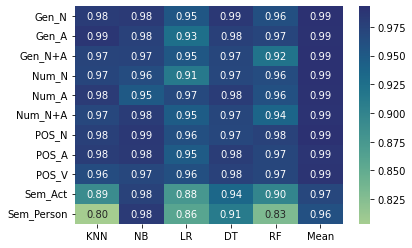

In [119]:
g = sns.heatmap(corr_df.applymap(lambda x: float(x)), annot=True, fmt=".2f", cmap="crest")
g.set_xticklabels(
    ['KNN', 'NB', 'LR', 'DT', 'RF', 'Mean'], rotation = 0)